In [ ]:
!pip install datasets pandas scikit-learn numpy -q
!pip install transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is incompatible.
torch 2.6.0+

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [ ]:
CATEGORY_MAPPING = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [ ]:
def load_and_preprocess_data():
    dataset = load_dataset("ag_news")
    train_df = pd.DataFrame(dataset['train'])
    test_df = pd.DataFrame(dataset['test'])

    train_df['Category'] = train_df['label'].map(CATEGORY_MAPPING)
    test_df['Category'] = test_df['label'].map(CATEGORY_MAPPING)

    return train_df, test_df

In [ ]:
def build_pipeline():
    """Build the SVM pipeline with TF-IDF features"""

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english')),
        ('svm', LinearSVC(C=1.0, dual=False, max_iter=5000,  random_state=42))
    ])
    return pipeline

In [ ]:
def get_param_grid():
    """Define the parameter grid for GridSearchCV"""
    param_grid = {
          'tfidf__max_features': [10000, 20000],
          'tfidf__ngram_range': [(1, 1),(1, 2)],
          'svm__C': [0.1, 1.0]
    }

    return param_grid


In [ ]:
def tune_hyperparameters(X_train, y_train, cv=3):
    """Find optimal hyperparameters using GridSearchCV"""
    pipeline = build_pipeline()

    # Define parameter grid
    param_grid = get_param_grid()

    # Create grid search
    print("Starting GridSearchCV...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        n_jobs=-1,  # Use all available cores
        verbose=3,
        scoring='accuracy'
    )

    # Fit grid search
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    print(f"GridSearchCV completed in {training_time:.2f} seconds")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

    return grid_search

In [ ]:
train_df, test_df = load_and_preprocess_data()
# Extract features and labels
X_train = train_df['text'].tolist()
y_train = train_df['label'].tolist()
X_test = test_df['text'].tolist()
y_test = test_df['label'].tolist()

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
pipeline = tune_hyperparameters(X_train, y_train, cv = 3)

Starting GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearchCV completed in 128.36 seconds
Best parameters: {'svm__C': 0.1, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best CV score: 0.9071


In [ ]:
pipeline_SVM = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english', max_features = 20000, ngram_range = (1, 2))),
    ('svm', LinearSVC(C=0.1, dual=False, max_iter=5000,  random_state=42))
])

In [ ]:
def find_n_components_by_variance(X, threshold):

    """Tìm số lượng thành phần với phương sai tích lũy vượt ngưỡng (threshold)"""

    tfidf = TfidfVectorizer(lowercase=True, stop_words='english')
    X_tfidf = tfidf.fit_transform(X)  # X_tfidf là ma trận thưa thớt

    svd = TruncatedSVD(n_components=min(X_tfidf.shape[1], 1000))  # Giới hạn số thành phần
    svd.fit(X_tfidf)  # Áp dụng TruncatedSVD trực tiếp lên ma trận thưa thớt

    cumulative_variance = svd.explained_variance_ratio_.cumsum()

    n_components = (cumulative_variance < threshold).sum() + 1  # Lấy thành phần cuối cùng đạt ngưỡng
    return n_components

In [ ]:
threshold = 0.95
n_components = find_n_components_by_variance(X_train, threshold)

In [ ]:
start_time = time.time()
pipeline_SVM.fit(X_train, y_train)
SVM_time = time.time() - start_time

In [ ]:
pipeline_PCA_SVM = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english', max_features=20000, ngram_range=(1, 2))),
    ("svd", TruncatedSVD(n_components=n_components)),  # Apply dimensionality reduction
    ('svm', LinearSVC(C=0.1, dual=False, max_iter=5000, random_state=42))  # LinearSVC for classification
])

start_time = time.time()
pipeline_PCA_SVM.fit(X_train, y_train)
PCA_SVM_time = time.time() - start_time

[CV 3/3] END svm__C=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 1);, score=0.905 total time=  10.6s
[CV 1/3] END svm__C=0.1, tfidf__max_features=20000, tfidf__ngram_range=(1, 1);, score=0.899 total time=  10.2s
[CV 2/3] END svm__C=0.1, tfidf__max_features=20000, tfidf__ngram_range=(1, 1);, score=0.909 total time=  10.8s
[CV 1/3] END svm__C=0.1, tfidf__max_features=20000, tfidf__ngram_range=(1, 2);, score=0.901 total time=  22.9s
[CV 1/3] END svm__C=1.0, tfidf__max_features=10000, tfidf__ngram_range=(1, 2);, score=0.888 total time=  22.8s
[CV 3/3] END svm__C=1.0, tfidf__max_features=20000, tfidf__ngram_range=(1, 1);, score=0.897 total time=  12.2s
[CV 2/3] END svm__C=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 1);, score=0.907 total time=  10.1s
[CV 2/3] END svm__C=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 2);, score=0.907 total time=  22.5s
[CV 3/3] END svm__C=0.1, tfidf__max_features=20000, tfidf__ngram_range=(1, 2);, score=0.910 total time=  23.8s
[

In [ ]:
# Evaluate on test set
start_time = time.time()
y_pred_SVM = pipeline_SVM.predict(X_test)
prediction_time_SVM = time.time() - start_time

start_time = time.time()
y_pred_PCA_SVM = pipeline_PCA_SVM.predict(X_test)
prediction_time_PCA_SVM = time.time() - start_time

# Calculate metrics
accuracy_SVM = accuracy_score(y_test, y_pred_SVM)
accuracy_PCA_SVM = accuracy_score(y_test, y_pred_PCA_SVM)
cm_SVM = confusion_matrix(y_test, y_pred_SVM)
cm_PCA_SVM = confusion_matrix(y_test, y_pred_PCA_SVM)


In [ ]:
import joblib

# Lưu pipeline đã huấn luyện
joblib.dump(pipeline_PCA_SVM, '/kaggle/working/PCA_SVM.pkl')
joblib.dump(pipeline_SVM, '/kaggle/working/SVM.pkl')

['/kaggle/working/SVM.pkl']

In [ ]:
print(f"SVM:")
print(f"Training Time: {SVM_time:.4f} seconds")
print(f"Prediction Time: {prediction_time_SVM:.4f} seconds")
print(f"Accuracy: {accuracy_SVM:.4f}")

print(f"SVM with PCA:")
print(f"Training Time: {PCA_SVM_time:.4f} seconds")
print(f"Prediction Time: {prediction_time_PCA_SVM:.4f} seconds")
print(f"Accuracy: {accuracy_PCA_SVM:.4f}")

SVM:
Training Time: 18.3377 seconds
Prediction Time: 0.5263 seconds
Accuracy: 0.9201
SVM with PCA:
Training Time: 210.4381 seconds
Prediction Time: 0.7632 seconds
Accuracy: 0.9001


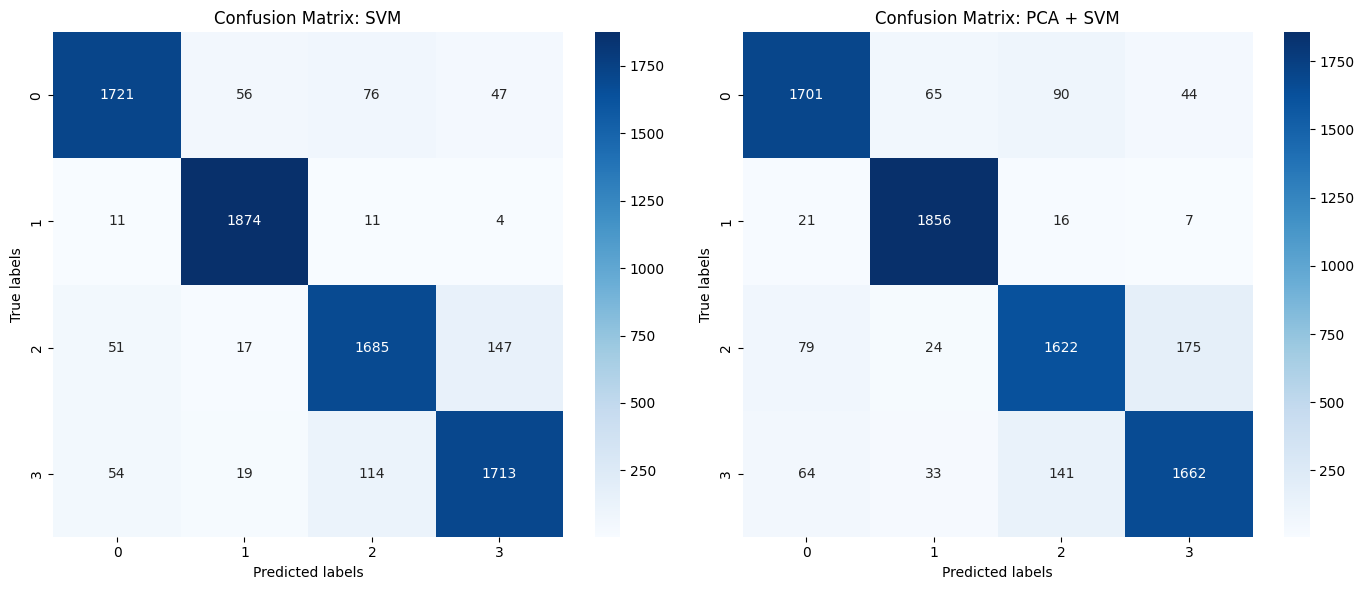

In [ ]:
confusion_matrices = {
    "SVM": cm_SVM,
    "PCA + SVM": cm_PCA_SVM
}
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix: {name}")
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")

plt.tight_layout()
plt.show()